# Speeding up model import and simulation - with a focus on large models

**Objective:** Give some hints to speed up import and simulation of larger models

This notebook gives some hints that may help to speed up import and simulation of (mostly) larger models. While some of these settings may also yield slight performance improvements for smaller models, other settings may make things slower. The impact may be highly model-dependent (number of states, number of parameters, rate expressions) or system-dependent and it's worthile doing some benchmarking.

To simulate models in AMICI, a model specified in a high-level format needs to be imported first, as shown in the following figure. This rougly involves the following steps:

1. Generating the ODEs
2. Computing derivatives
3. Generating C++ code
4. Compiling the generated code
5. Simulating the model

![AMICI workflow](https://raw.githubusercontent.com/AMICI-dev/AMICI/master/documentation/gfx/amici_workflow.png)

There are various options to speed up individual steps of this process. Generally, faster import comes with slower simulation and vice versa. During parameter estimation, a model is often imported only once, and then millions of simulations are run. Therefore, faster simulation will easily compensate for slower import (one-off cost). In other cases, many models may to have to be imported, but only few simulations will be executed. In this case, faster import may bee more relevant.

In the following, we will present various settings that (may) influence import and simulation time. We will follow the order of steps outlined above.

Since many of the following demonstrations take quite some time to compute, this notebook mostly shows pre-generated results.

In [1]:
from IPython.core.pylabtools import figsize, getfigs
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 12})

## Examples

The demos below make use of the following models contained in the [PEtab benchmark collection](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab) and other publications:

| Model                                                                                                                                                    | # parameters | # states |
|----------------------------------------------------------------------------------------------------------------------------------------------------------|--------------|----------|
| [Chen_MSB2009](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab/tree/master/Benchmark-Models/Chen_MSB2009)                              | 155          | 500      |
| [Froehlich_CellSystems2018](https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab/tree/master/Benchmark-Models/Froehlich_CellSystems2018)    | 4231         | 1396     |
| [FröhlichGer2022 (RTKERK__base)](https://doi.org/10.1101/2022.02.17.480899)                                                                              | 105          | 2272     |
| [hello_pysb](https://github.com/pysb/pysb/blob/master/pysb/examples/hello_pysb.py)                                                                       | 4            | 3        |

All data has been generated with AMICI v0.15.0 or v0.16.0 unless stated otherwise.

## Model import

### Symbolic processing

#### Parameters as constants

By default, AMICI will generate sensitivity equations with respect to all model parameters. If it is clear upfront, that sensitivities with respect to certain parameters will not be required, their IDs can be passed to [amici.sbml_import.SbmlImporter.sbml2amici](https://amici.readthedocs.io/en/latest/generated/amici.sbml_import.SbmlImporter.html#amici.sbml_import.SbmlImporter.sbml2amici) or [amici.pysb_import.pysb2amici](https://amici.readthedocs.io/en/latest/generated/amici.pysb_import.html?highlight=pysb2amici#amici.pysb_import.pysb2amici) via the `constant_parameters` to not generate the respective equations. This will reduce CPU time and RAM requirements during import and simulation.
The PEtab import will take care of that automatically.

See also the following section for that case that no sensitivities are required at all.


#### Not generating sensivitiy code

If only forward simulations of a model are required, a modest import speedup can be obtained from not generating sensitivity code. This can be enabled via the `generate_sensitivity_code` argument of [amici.sbml_import.SbmlImporter.sbml2amici](https://amici.readthedocs.io/en/latest/generated/amici.sbml_import.SbmlImporter.html#amici.sbml_import.SbmlImporter.sbml2amici) or [amici.pysb_import.pysb2amici](https://amici.readthedocs.io/en/latest/generated/amici.pysb_import.html?highlight=pysb2amici#amici.pysb_import.pysb2amici).

Example:
```bash
petab_yaml="https://raw.githubusercontent.com/Benchmarking-Initiative/Benchmark-Models-PEtab/master/Benchmark-Models/Froehlich_CellSystems2018/Froehlich_CellSystems2018.yaml"
/usr/bin/time -v amici_import_petab -y "$petab_yaml" --no-compile
# vs.
/usr/bin/time -v amici_import_petab -y "$petab_yaml" --no-compile --no-sensitivities
```

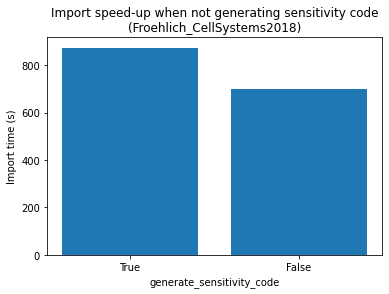

speedup: 1.25x


In [2]:
figsize(4, 4)
plt.bar(["True", "False"], [873.54, 697.85])
plt.xlabel("generate_sensitivity_code")
plt.ylabel("Import time (s)")
plt.title("Import speed-up when not generating sensitivity code\n(Froehlich_CellSystems2018)");
plt.show()

print(f"speedup: {873.54/697.85:.2f}x")

#### Extracting common subexpressions

For some models, the size of the generated model code can be significantly reduced by extracting common subexpressions. This can yield substantial reductions of compile times and RAM-requirements. Very large models might not compile without this option. Extracting common subexpressions can be enabled by setting an environment variable `AMICI_EXTRACT_CSE=1` before model import.
The downside is, that the generated model code becomes rather unreadable. The increase in import time when enabling this feature is usually <15%, the effect on code size and compile time is highly model dependent. Mostly models with tightly coupled ODEs, as obtained from complex rate laws or spatial discretizations of ODEs, seem to benefit. For models with mass action kinetics, this option seems to not be helpful and rather increases compile time (e.g., for FröhlichGer2022, the compile time doubles).

Benchmark result from [here](https://github.com/AMICI-dev/AMICI/pull/1852) (SBML import, `AMICI_IMPORT_NPROCS=2`, sequential compilation with clang14, `CFLAGS=-O2`):

|                     | default        | `AMICI_EXTRACT_CSE=1` |
|---------------------|----------------|-----------------------|
| import time         | 160 min (100%) | 164 min (103%) |
| code size           | 89 MB (100%)   | 27 MB (30%)    |
| compile time        | 169 min (100%) | 90 min (53%)   |
| compile RAM         | 7.49 GB (100%) | 1.18 GB (16%)  |
| simulation time (*) | 100%           | 97%            |

(*) lowest out of 20 identical simulations using ASA

#### Parallelization

For large models or complex model expressions, symbolic computation of the derivatives can be quite time consuming. This can be parallelized by setting the environment variable `AMICI_IMPORT_NPROCS` to the number of parallel processes that should be used. The impact strongly depends on the model. Note that setting this value too may have a negative performance impact (benchmark!).

Impact for a large and a tiny model:

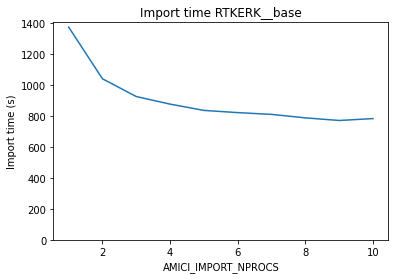

Import time decreased by up to ~44%.


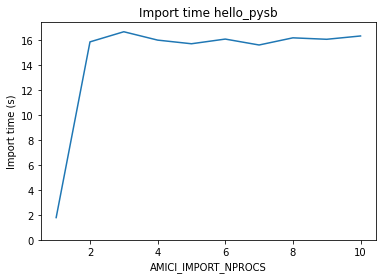

Import time increased by at least ~774%.


In [3]:
df_import = pd.read_csv("results_import.tsv", sep="\t")
for model_name, df in df_import.groupby("model_name"):
    plt.plot(df.nprocs, df.time)
    plt.title(f"Import time {model_name}")
    plt.xlabel("AMICI_IMPORT_NPROCS")
    plt.ylabel("Import time (s)")
    plt.ylim(ymin=0)
    plt.show()
    
    import_times = df.sort_values("nprocs")["time"].values
    percent_change = (import_times[0] - min(import_times[1:])) / import_times[0] * 100
    if percent_change > 0:
        print(f"Import time decreased by up to ~{percent_change:.0f}%.")
    else:
        print(f"Import time increased by at least ~{-percent_change:.0f}%.")

### Compilation

#### Choice of compiler

From own experience, `clang` seems to handle larger models, or more specifically, their large source files, better than `g++`, both in terms of memory requirement and compile time. You can use a different compiler by setting the `CC` and `CXX` environment variables to, e.g., `CC=clang`, `CXX=clang`.

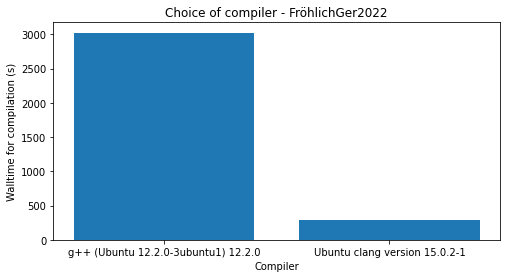

Clang was ~10x as fast as g++.


In [4]:
figsize(8, 4)
compilation_time_s = [3022.453, 289.518]
labels = ["g++ (Ubuntu 12.2.0-3ubuntu1) 12.2.0", "Ubuntu clang version 15.0.2-1"]
plt.bar(labels, compilation_time_s)
plt.ylim(ymin=0)
plt.title("Choice of compiler - FröhlichGer2022")
plt.xlabel("Compiler")
plt.ylabel("Walltime for compilation (s)");
plt.show()
print(f"Clang was ~{compilation_time_s[0] / compilation_time_s[1]:.0f}x as fast as g++.")

#### Parallel compilation

It's possible to compile multiple source files in parallel by specifying the number of parallel processes via the `AMICI_PARALLEL_COMPILE` environment variable. This is also beneficial for small models.
Note, however, that for large models, this may require significant amounts of RAM. 

Example for a large and tiny model:

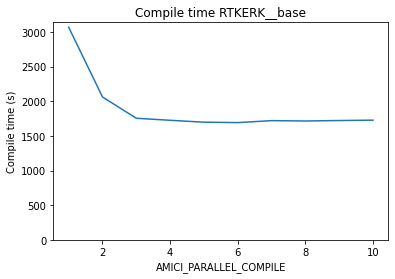

We were able to reduce compile time by up to ~45%.


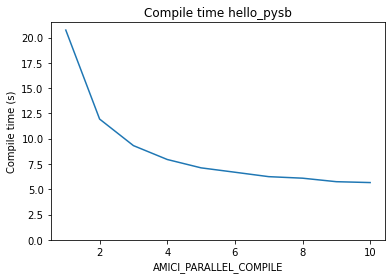

We were able to reduce compile time by up to ~73%.


In [5]:
df_compile = pd.read_csv("results_compile.tsv", sep="\t")
figsize(6, 4)

for model_name, df in df_compile.groupby("model_name"):
    plt.plot(df.nprocs, df.time)
    plt.title(f"Compile time {model_name}")
    plt.xlabel("AMICI_PARALLEL_COMPILE")
    plt.ylabel("Compile time (s)")
    plt.ylim(ymin=0)
    plt.show()
    
    compilation_time_s = df.sort_values("nprocs")["time"].values
    print("We were able to reduce compile time by up to "
          f"~{(compilation_time_s[0] - min(compilation_time_s[1:])) / compilation_time_s[0] * 100:.0f}%.")

#### Compiler flags

For most compilers, different machine code optimizations can be enabled/disabled by the `-O0`, `-O1`, `-O2`, `-O3` flags, where a higher number enables more optimizations. For fastet simulation, `-O3` should be used. However, these optimizations come at the cost of increased compile times. If models grow very large, some optimizations (especially with `g++`, see above) become prohibitively slow. In this case, a lower optimization level may be necessary to be able to compile models at all.

Another potential performance gain can be obtained from using CPU-specific instructions using `-march=native`. The disadvantage is, that the compiled model extension will only run on CPUs supporting the same instruction set. This may be become problematic when attempting to use an AMICI model on a machine other than on which it was compiled (e.g. on hetergenous compute clusters).

These compiler flags should be set for both, AMICI installation installation and model compilation. 

For AMICI installation, e.g.,
```bash
CFLAGS="-O3 -march=native" pip install amici
```

For model compilation, flags can be passed via the `AMICI_CXXFLAGS` environment variable.


Example:
```bash
petab_yaml="https://raw.githubusercontent.com/Benchmarking-Initiative/Benchmark-Models-PEtab/master/Benchmark-Models/Chen_MSB2009/Chen_MSB2009.yaml"
amici_import_petab -y "${petab_yaml}" --no-compile
cd Chen_MSB2009-amici0.16.0/
for O in "-O0" "-O1" "-O2" "-O3" "-O3 -march=native"
    # this line only builds the model extension, and is normally performed automatically during import
    do AMICI_PARALLEL_COMPILE=1 AMICI_CXXFLAGS=-O${O} /usr/bin/time -v python setup.py build_ext --force --build-lib .
done
```

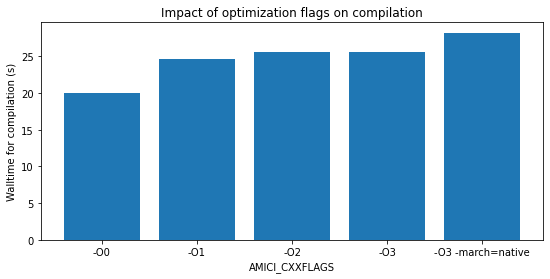

In [6]:
compilation_time_s = [20.01, 24.62, 25.59, 25.63, 28.21]
labels = ["-O0", "-O1", "-O2", "-O3", "-O3 -march=native"]
figsize(9, 4)
plt.bar(labels, compilation_time_s)
plt.title("Impact of optimization flags on compilation")
plt.xlabel("AMICI_CXXFLAGS")
plt.ylabel("Walltime for compilation (s)");

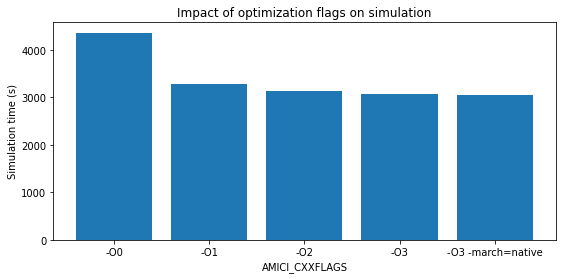

In [7]:
plt.bar(
    ["-O0", "-O1", "-O2", "-O3", "-O3 -march=native"],
    [4357.768, 3276.873, 3140.092, 3069.855, 3039.262],
)
plt.title("Impact of optimization flags on simulation")
plt.xlabel("AMICI_CXXFLAGS")
plt.ylabel("Simulation time (s)");

#### Using some optimized BLAS

You might have access to some custom [BLAS](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms) optimized for your hardware which might speed up your simulations somewhat. We are not aware of any systematic evaluation and cannot make any recomendation. You pass the respective compiler and linker flags via the environment variables `BLAS_CFLAGS` and `BLAS_LIBS`, respectively.

## Model simulation

A major determinant of simulation time for a given model is the required accuracy and the selected solvers. This has been evaluated, for example, in https://doi.org/10.1038/s41598-021-82196-2 and is not covered further here. 

### Adjoint *vs.* forward sensivities

If only the objective function gradient is required, adjoint sensitivity analysis are often preferable over forward sensitivity analysis. As a rule of thumb, adjoint sensitivity analysis seem to outperform forward sensitivity analysis for models with more than 20 parameters:

![](https://journals.plos.org/ploscompbiol/article/figure/image?size=medium&id=10.1371/journal.pcbi.1005331.g002)
*CC BY 4.0 Fröhlich et al., https://doi.org/10.1371/journal.pcbi.1005331*

### Sensitivities w.r.t. a subset of parameters

If only sensitivities with respect to a subset of model parameters are of interest to you (see also *Parameters as constants* above), you can speed up the simulation by selecting the relevant parameter indices via [amici.Model.setParameterList](https://amici.readthedocs.io/en/latest/generated/amici.amici.Model.html#amici.amici.Model.setParameterList).



### Parallel simulation of multiple conditions

Whenever there are multiple independent simulations to perform, you can use [amici.runAmiciSimulations(..., num_threads=...)](https://amici.readthedocs.io/en/latest/generated/amici.amici.html#amici.amici.runAmiciSimulations) instead of [amici.runAmiciSimulations(...)](https://amici.readthedocs.io/en/latest/generated/amici.amici.html#amici.amici.runAmiciSimulation) to run them in parallel. Note that all simulation results have to be kept in memory, which may become problematic for very large numbers of simulations.
Parallelization is based on OpenMP and does not come with the issues associated with Python's multiprocessing or multithreading (spawning extra processes or limitations related to the global interpreter lock).

### Reporting mode

During model simulation, many quantities are calculated, but not all might be of interest for you. For example, for parameter estimation you might only be interested in the likelihood and gradient. In this case, you can save time and memory using  
[amici.Solver.setReturnDataReportingMode(amici.RDataReporting.likelihood)](https://amici.readthedocs.io/en/latest/generated/amici.amici.Solver.html#amici.amici.Solver.setReturnDataReportingMode).